In [1]:
%matplotlib inline 
from IPython.core.display import display, Math, Latex

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from sympy import *
import sympy
from sympy.plotting import plot, plot3d, plot3d_parametric_line, plot3d_parametric_surface
import matplotlib.figure
init_printing()
#from math import *
from interval import interval
from interval import imath
import sys
from pprint import pprint


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
from numpy.random import seed
import pandas as pd

In [2]:
%run ivmat

## 2. $f(\theta)$の最小化

### 2.1 評価関数 $f(\theta)$ の定義
- $f(\mathbf{\theta})$を最小化する

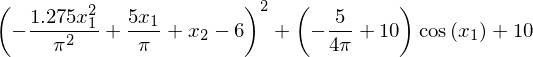

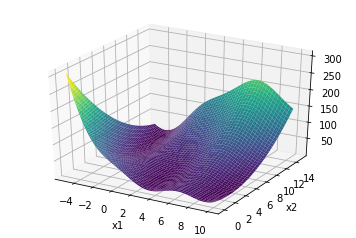

In [3]:
theta = var('x1 x2')

a = 1
b = 5.1 / (4*(pi**2))
c = 5 / pi
r = 6
s = 10
t = 1 / (8*pi)

f_expr =  a*(x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*cos(x1) + s
display(f_expr)

plot3d(f_expr, (x1, -5, 10), (x2, 0, 15), xlabel='x1', ylabel='x2')


f = lambdify(theta, f_expr, "numpy")

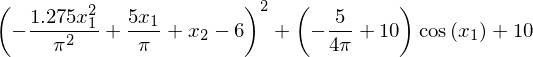

In [4]:
display(f_expr)

In [5]:
x1_min, x1_max = (-5, 10)
x2_min, x2_max = (0, 15)
x1_interval = (x1_max - x1_min)/ 100.
x2_interval = (x2_max - x2_min)/ 100.

#fig = plot3d(f_expr, (x1, x1_min, x1_max), (x2, x2_min, x2_max), title='$f(x1, x2)$')

x = np.arange(x1_min, x1_max, x1_interval) # length scale
y = np.arange(x2_min, x2_max, x2_interval) # noise 
X1, X2 =  np.meshgrid(x, y)

np_f = lambdify(theta, f_expr, np)
f = lambdify(theta, f_expr, modules=(imath))
Z = np.array([np_f(*x) for x in np.array([X1.flatten(), X2.flatten()]).T ]).reshape(X1.shape)

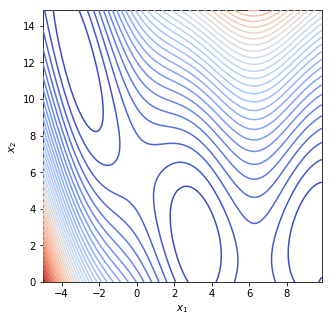

In [6]:
plt.figure(figsize=(5,5))
# plt.xscale('log')
# plt.yscale('log')
plt.contour(X1, X2, Z, 40, zorder=1000, shading='gouraud', cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

# data = np.array([(float(-pi.evalf()), 12.275), (float(pi.evalf()), 2.275), (9.42478, 2.475) ])
# score = [f(*x) for x in data]
# plt.scatter(data[:,0], data[:, 1], s=100, c='red', marker="o")

### 2.2 $\dfrac{\partial}{\partial \theta}f(\theta)$の計算

In [7]:
display(theta)
df_expr = [[f_expr.diff(_theta)] for _theta in theta]
df = []
for row_expr in df_expr:
    tmp = []
    for _df_expr in row_expr:
        res = lambdify(theta, _df_expr, modules=(imath))
        tmp.append(res)
    df.append(tmp)
df = fmat(df)

print(type(df))
print(df)

<class '__main__.fmat'>
[[<function <lambda> at 0x10be0ea28>], [<function <lambda> at 0x10d28e9b0>]]


### 2.3 $\dfrac{\partial^{2}}{\partial \theta^{2}}f(\theta)$の計算

In [8]:
ddf_expr = hessian(f_expr, theta)

In [9]:
ddf = []
for i in range(ddf_expr.shape[0]):
    tmp = []
    for j in range(ddf_expr.shape[1]):
        res = lambdify(theta, ddf_expr[i, j], modules=(imath))
        tmp.append(res)
    ddf.append(tmp)

ddf = fmat(ddf)    
ddf

[[<function interval.imath.<lambda>>, <function interval.imath.<lambda>>],
 [<function interval.imath.<lambda>>, <function interval.imath.<lambda>>]]

## Krawczykで全解探索

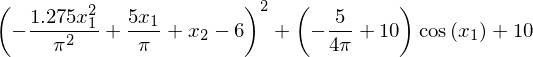

[[interval([-5.0, 10.0])], [interval([0.0, 15.0])]]
(2, 1)
Loop end. cnt:70, len(S):0, len(T):8, len(U):0

70
---------- 最終的なS[:10] -----------
[]
---------- 最終的なU[:10] -----------
[]
---------- 最終的なT[:10] -----------
[[[interval([2.6275443566622996, 3.591640886180247])],
  [interval([1.7893073799920725, 2.7871956653501644])]],
 [[interval([6.188712272905713, 6.425767561183246])],
  [interval([1.041196650819442, 1.1553165898892273])]],
 [[interval([2.931270589938586, 3.3573300990037933])],
  [interval([2.0326958863402877, 2.5101399771666624])]],
 [[interval([6.108547238783478, 6.410264186739888])],
  [interval([1.003286297266509, 1.18299278292127])]],
 [[interval([9.29187901149956, 9.542773903611893])],
  [interval([2.3015889135251846, 2.6177449195085964])]],
 [[interval([-0.3231767202470058, 0.31141159948313807])],
  [interval([5.526122277022422, 6.4932957559492275])]],
 [[interval([-0.0859496954406874, 0.0855551430010649])],
  [interval([5.869197020287796, 6.1306264336298675])]],
 [[

In [10]:
display(f_expr)
X = ivmat([[interval[-5, 10]],[interval[0, 15]]])

#X = ivmat([[interval[-2.1, 2]],[interval[-2.1, 2]]])
print(X)
print(X.shape)
kra = Krawczyk(df, ddf ,X)

cnt_max = 1000
max_width = 1e-6
ans_boxes, s_num_list, t_num_list, u_num_list, animation_boxes = kra.find_all_solution(trace=False, cnt_max=cnt_max, max_width=max_width)

## ddf.diag > 0 なら全変数が下に凸

In [11]:
min_points = []

for X in ans_boxes:    
    args = [x[0] for x in X]
    f_val = f(*args)
    ddf_diag =  ddf.apply_args(X).diag
    if not ddf_diag > 0:
        continue
    df_val = df.apply_args(X)
    print(f_val.midpoint)
    min_point =  [x[0] for x in X.midpoint.to_scalar()]    
    print min_point
    min_points.append(min_point)
    print
    
min_points = np.array(min_points)

interval([0.39788735773])
[3.141592653589794, 2.2749999999999995]

interval([0.39788735773])
[3.141592653589793, 2.2749999999999995]

interval([0.39788735773])
[9.42477796076938, 2.4750000000000014]

interval([0.39788735773])
[-3.1415926535898926, 12.274999999999999]



[[  3.14159265   2.275     ]
 [  3.14159265   2.275     ]
 [  9.42477796   2.475     ]
 [ -3.14159265  12.275     ]]


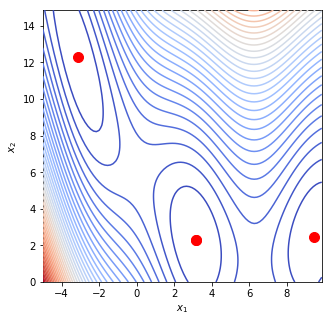

In [12]:
print min_points

plt.figure(figsize=(5,5))
# plt.xscale('log')
# plt.yscale('log')
plt.contour(X1, X2, Z, 40, zorder=1000, shading='gouraud', cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')


score = [f(*x) for x in min_points]
plt.scatter(min_points[:,0], min_points[:, 1], s=100, c='red', marker="o")

KeyboardInterrupt: 

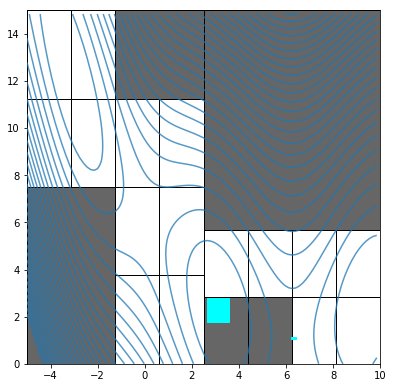

In [13]:
x1_min, x1_max = x1_lim = (-5, 10)
x2_min, x2_max = x2_lim = (0, 15)
x1_interval = (x1_max - x1_min)/ 100.
x2_interval = (x2_max - x2_min)/ 100.

x = np.arange(x1_min, x1_max, x1_interval) # length scale
y = np.arange(x2_min, x2_max, x2_interval) # noise 
X, Y =  np.meshgrid(x, y)

f = lambdify(theta, f_expr, np)
Z = np.array([f(*x) for x in np.array([X.flatten(), Y.flatten()]).T ]).reshape(X.shape)



def get_rect(x_1, x_2, facecolor_code, edgecolor_code):
    left, right, below, above = x_1[0][0], x_1[0][1], x_2[0][0], x_2[0][1]
    rect = Rectangle((left, below),
                    right - left,
                    above - below,
                    facecolor= facecolor_code,
                    edgecolor=edgecolor_code
                    )
    return rect


_NO_SOLUTIONS_FLAG = '_NO_SOLUTIONS_FLAG'
_EXACT_1_SOLUTION_FLAG = '_EXACT_1_SOLUTION_FLAG'
_MULTI_SOLUTIONS_FLAG = '_MULTI_SOLUTIONS_FLAG'  # less than 1 solution
_UNCLEAR_SOLUTION_FLAG = '_UNCLEAR_SOLUTION_FLAG'

# facecolor, edgecolor
color_map ={
    _NO_SOLUTIONS_FLAG: ("#666666", "#000000"),
    _UNCLEAR_SOLUTION_FLAG:("#ffffff", "#000000" ),
    _EXACT_1_SOLUTION_FLAG: ("#00ffff", "#00ffff"),
}


animation_box = animation_boxes
for i in range(len(animation_box)):
    if i % 2 != 0:
        continue        
    fig = plt.figure(figsize=(8, 6.5))
    plt.xlim(x1_lim)
    plt.ylim(x2_lim)
    ax = fig.add_subplot(111)
    for j in range(i):
        for parent_box, parent_flag in animation_box[j]:
#        parent_box, parent_flag = animation_box[j]
            fcolor, ecolor = color_map[parent_flag]# facecolor, edgecolor
            parent_x1 = parent_box[0][0]
            parent_x2 = parent_box[1][0]
            if ivmat.is_empty(parent_box):
                continue
            rect = get_rect(parent_x1, parent_x2, fcolor, ecolor)
            ax.add_patch(rect)
        
    # 最後にcolor mapを薄く重ねる
    ax.set_aspect('equal')
    im =plt.contour(X, Y, Z, 40, alpha=0.75, zorder=1000, shading='gouraud')    
    fig.colorbar(im)
    #plt.show()
    fig.savefig("image/anime_{0:0>4}.png".format(i))
    plt.close(fig)
    